In [1]:
# 3rd party imports
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as plt
import geopandas as gpd
import pyproj
import plotly.express as px
import janitor as jn
import numpy as np
import matplotlib.pylab as pylab

# Configure Notebook
#for plots to be inline
%matplotlib inline 
#for auto_complete 
%config Completer.use_jedi = False 

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

#hiding warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#location for each file and folder
folder_plowed = r'src/17_joined_streets'
file_plowed = r'joined_streets.geojson'

neighbourhoods_folder = r'src/17_Neighbourhoods_cleaned'
neighbourhoods_file = r'NeighbourhoodS_cleaned.shp'

total_length_folder = r'src/Length of Streets'
total_length_file = r'CENTRELINE_WGS84.geojson'

total_lengths_out_folder = r'src/17_total_lengths'
total_lengths_out_file = r'17_total_lengths.csv'

final_df_folder = r'src/17_final_plowed_df'
final_df_file = r'17_final_plowed_df.geojson'

start_time = pd.to_datetime('2022-02-17 17:00')
end_time = pd.to_datetime('2022-02-19 9:00')

In [3]:
def import_plowed_streets():
 
    plowed_streets = gpd.read_file(os.path.join(os.getcwd(), folder_plowed, file_plowed))
    plowed_streets.index = pd.DatetimeIndex(plowed_streets['completed_time'])

    #adding crs info to df
    plowed_streets.crs = {'init':'epsg:4326'}
    plowed_streets = plowed_streets.to_crs('EPSG:4326')

    #capturing the centroid from each street
    plowed_streets['centroid'] = plowed_streets['geometry'].centroid

    #Because many lines will be repeated
    plowed_streets.drop_duplicates(inplace=True)
    
    return plowed_streets


In [4]:
def get_total_street_lengths_neighbourhoods(save_files = True):
    #Reading and filtering out useless columns in the streets centreline dataset
    line_streets = gpd.read_file(os.path.join(os.getcwd(), total_length_folder, total_length_file))
    line_streets = line_streets[['LINEAR_NAME_FULL',
                       'LINEAR_NAME_FULL_LEGAL',
                       'LINEAR_NAME',
                       'LINEAR_NAME_TYPE',
                       'ONEWAY_DIR_CODE_DESC',
                       'JURISDICTION',
                       'FEATURE_CODE_DESC',
                       'Shape__Length',
                       'geometry']].dropna(subset=['LINEAR_NAME_TYPE'])

    streets_unused = ['Trl',
                     #'Mews',
                     'Pk',
                     'Walk',
                     'Ptwy',
                     'Path',
                     'Wkwy']

    #Preparing to localize each stretch of street into a neighbourhood: creating centroid column
    line_streets = line_streets[~line_streets['LINEAR_NAME_TYPE'].isin(streets_unused)]
    line_streets = line_streets[line_streets.JURISDICTION == 'CITY OF TORONTO']
    line_streets['centroid'] = line_streets['geometry'].centroid
    line_streets['savedgeom'] = line_streets.geometry

    #Importing the neighbourhoods dataset (previously cleaned)
    neighbourhoods = gpd.read_file(os.path.join(os.getcwd(), neighbourhoods_folder, neighbourhoods_file))

    #Joining both dataframes, to put each stretch of road into a neighbourhood
    joined_df = gpd.sjoin(left_df=line_streets, 
                          right_df=neighbourhoods, 
                         op = 'within').drop(columns={'index_right','id'})
    #grouping by the name of the neighbourhood, and the type of road (local, collector, major etc)
    neighbourhoods_street_lengths = joined_df.groupby(by=['name_neigh', 'FEATURE_CODE_DESC']).agg(length = ('Shape__Length','sum'),
                                                                 area = ('area','first'))
    #saving file to be used later on.
    if os.path.isdir(total_lengths_out_folder) == False:
        os.mkdir(os.path.join(os.getcwd(), total_lengths_out_folder))
    
    if save_files == True:
        neighbourhoods_street_lengths.to_csv(os.path.join(os.getcwd(), total_lengths_out_folder, total_lengths_out_file))
    return neighbourhoods_street_lengths, joined_df

In [5]:
def include_length_ratio():
    
    plowed_df = import_plowed_streets()
    
    #reading the df containing the total length of each type of street inside each neighbourhood
    total_streets = pd.read_csv(os.path.join(total_lengths_out_folder, total_lengths_out_file))
    total_streets.rename(columns={'name_neigh':'neighbourhood'}, inplace=True)
    total_streets.rename(columns={'FEATURE_CODE_DESC':'route_name'}, inplace=True)

    #at this point, we need to know the total length of any given type of street inside each neighbourhood, add this information to the
    #plowed streets df, so we can finally know the ratio of a given type of street that has been plowed inside a neighbourhood
    #example: 73% of major road have been plowed in the "Humber West" neighbourhood.
    total_temp = pd.merge(left=plowed_df, right=total_streets, on=['neighbourhood','route_name'], how='left')
    plowed_df['total_length'] = total_temp['length_y'].values #this is the only useful column from the merged df
    plowed_df['length_ratio'] = 100*plowed_df['length']/plowed_df['total_length']
    
    plowed_df = plowed_df.drop(columns={'completed_time'})
    
    #this is the final df, so we will save it for now
    if os.path.isdir(final_df_folder) == False:
        os.mkdir(os.path.join(os.getcwd(), final_df_folder))
    plowed_df.drop(columns={'centroid'}).to_file(os.path.join(final_df_folder, final_df_file), driver='GeoJSON')

In [6]:
def add_missing_rows_plowed():
    #adding missing rows to include unplowed neighbourhoods per each timestamp
    #reading the df containing the total length of each type of street inside each neighbourhood
    neighbourhoods = gpd.read_file(os.path.join(neighbourhoods_folder, neighbourhoods_file))
    neighbourhoods.rename(columns={'name_neigh':'neighbourhood'}, inplace=True)

    plowed_df = gpd.read_file(os.path.join(final_df_folder, final_df_file))
    filled_df = plowed_df.reset_index()

    filled_df = filled_df.complete('completed_time', 'neighbourhood', 'route_name')
    df = pd.merge(left=filled_df, right=neighbourhoods, on=['neighbourhood'], how='left')
    df.geometry = df.geometry_y
    df.drop(columns={'geometry_x', 'geometry_y', 'area', 'id'}, inplace=True)
    df = df.fillna(0)
    
    #Saving to file
    df.to_file(os.path.join(final_df_folder, r'17_printable_final_df.geojson'), driver='GeoJSON')

In [7]:
def main():
    import_plowed_streets()
    get_total_street_lengths_neighbourhoods()
    include_length_ratio()
    add_missing_rows_plowed()

In [8]:
#this function only has to be run once.
#The graph plotting functions will tap into the saved dfs and geojson files that the main function creates.
if os.path.isfile(os.path.join(final_df_folder, r'17_printable_final_df.geojson')) == False:
    print('Final file not found, running main script now')
    main()
else:
    print('Final file found, skipping main function')

Final file not found, running main script now


In [9]:
def plot_map(save_map=True):
    
    try:
        df1
    except NameError:
        neighbourhoods = gpd.read_file(os.path.join(os.getcwd(), neighbourhoods_folder, neighbourhoods_file))
        neighbourhoods['id'] = neighbourhoods['name_neigh']
        neighbourhoods.drop(['name_neigh', 'area'], axis=1, inplace=True)
        neighbourhoods.index = neighbourhoods['id']
        neighbourhoods_json = json.loads(neighbourhoods.to_json())

        #The map will print only one type of road, to be more representative.
        level = 'Local' #out of ['Local', 'Minor Arterial', 'Laneway', 'Major Arterial', 'Other','Collector', 'Major Arterial Ramp', 'Expressway', 'Expressway Ramp','Pending', 'Collector Ramp', 'Access Road']

        df1 = gpd.read_file(os.path.join(final_df_folder, r'17_printable_final_df.geojson'))
        df1 = df1[df1.route_name == level]

        df1['completed_time'] = pd.to_datetime(df1['completed_time'])
        df1 = df1[df1.completed_time >= start_time]
        df1 = df1[df1.completed_time <= end_time]
        df1.rename(columns={'length_ratio':'% plowed'}, inplace=True)
        df1.sort_values(by='completed_time', inplace=True)
        df1['Day and Hour'] = df1['completed_time'].dt.strftime("%d at %Hh")
        df1.drop(['completed_time','route_name','routetype','length', 'total_length', 'geometry'], axis=1, inplace=True)

    #using plotly for an animated choropleth map
    fig2 = px.choropleth_mapbox(df1,
                               geojson=neighbourhoods_json,
                               locations=df1.neighbourhood,
                               color='% plowed',
                               center={'lat':43.72, 'lon':-79.38},
                               mapbox_style='open-street-map',
                               zoom=9,
                               color_continuous_scale='blues',
                               range_color=(0, 30),
                               animation_frame='Day and Hour',
                               width=800,
                               height=600)
    if save_map == True:
        fig2.write_html("17_map_v3_local.html")
    fig2.show()

In [ ]:
#load map only if needed, since it is REALLY heavy on memory.
plot_map(save_map=False)

In [12]:
 try:
    weather
except NameError:
    print('weather data not found, grabbing it now')
    weather = pd.read_csv('src/Weather Data/YTZ_weather.csv')
    columns_keep = ['Precip. Amount (mm)', 'Date/Time (LST)']
    weather = weather[columns_keep]
    weather['Date/Time (LST)'] = pd.to_datetime(weather['Date/Time (LST)'])
    weather = weather[weather['Date/Time (LST)'] >= start_time]
    weather = weather[weather['Date/Time (LST)'] <= end_time]
    weather['Day and Hour'] = weather['Date/Time (LST)'].dt.strftime("%d at %Hh")
    weather.rename({'Precip. Amount (mm)':'Snowfall (mm)'}, axis=1, inplace=True)
    
try:
    total_per_district
except NameError:
   # Do something.
    print('df per district not found, grabbing it now')
    street_lengths, joined_df = get_total_street_lengths_neighbourhoods()
    neighbourhoods = gpd.read_file(os.path.join(os.getcwd(), neighbourhoods_folder, neighbourhoods_file))

    plowed = gpd.read_file(os.path.join(final_df_folder, r'17_printable_final_df.geojson'))
    districts_plowed = plowed.groupby(by=['completed_time','routetype']).agg(length=('length','sum'))

    boundaries = gpd.read_file('src/Council Boundaries/council_bound.geojson')
    columns=['AREA_NAME','geometry']
    boundaries = boundaries[columns]

    boundaries_df = gpd.sjoin(left_df=joined_df, 
                              right_df=boundaries, 
                             op = 'within')
    boundaries_df = boundaries_df.groupby(['AREA_NAME', 'FEATURE_CODE_DESC']).agg(length = ('Shape__Length', 'sum'))



    rename_dict = {'Etobicoke York Community Council':'Etobicoke', 'North York Community Council':'North York', 
                   'Scarborough Community Council':'Scarborough',
                   'Toronto and East York Community Council':'Toronto / East York'}
    boundaries_df.rename(mapper=rename_dict, inplace=True)

    boundaries_total = boundaries_df.groupby(by='AREA_NAME').agg(length_total = ('length', 'sum'))
    boundaries_total.reset_index(inplace=True)

    districts_plowed.reset_index(inplace=True)

    total_per_district = pd.merge(left=districts_plowed, right=boundaries_total, left_on='routetype', right_on='AREA_NAME')
    total_per_district['ratio'] = 100*total_per_district['length']/total_per_district['length_total']
    total_per_district['dt_time'] = pd.to_datetime(total_per_district['completed_time'])
    total_per_district = total_per_district[total_per_district.dt_time >= start_time]
    total_per_district = total_per_district[total_per_district.dt_time <= end_time]
    total_per_district['time'] = total_per_district['dt_time'].dt.strftime("%d at %Hh")

def plot_districts(save_fig=True):
    #Plotting the graph
    #First, setting parameters for it
    print('Initializing figure')
    plt.figure(figsize=(15,12))

    #setting palette to be used
    palette = {'Etobicoke':'C0', 'North York':'C1', 'Scarborough':'C2', 'Toronto / East York':'C3'}

    #plotting line data, but keeping colors consistent by using palette argument
    print('plotting first axis')
    ax = sns.lineplot(data=total_per_district,
                 x='time', 
                    y='ratio', 
                 hue='AREA_NAME',
                     palette=palette)
    #this snippet will hide the barplot behind the lineplot
    
    ax.set_zorder(10)
    ax.patch.set_visible(False)

    #plotting snowfall data on secondary axis
    print('plotting secondary axis')
    ax2 = ax.twinx()
    sns.barplot(data=weather, x='Day and Hour', y='Snowfall (mm)', ax=ax2, color='grey', alpha=0.2, label='Snowfall')

    #PArameter configs:
    #Reduce number of xticks to 15 bins
    ax.xaxis.set_major_locator(plt.MaxNLocator(15))

    print('Configuring ticks and limits')
    #plt.xticks(rotation='vertical')
    ax.set_ylim(0,40)
    ax2.set_ylim(0,2)

    print('Title and axis labels')
    plt.title('Behaviour of Snow Plows per district: Peaks at the same time, but differing intensities.', fontsize=20)
    ax.set_ylabel('Ratio of plowed roads (%)', fontsize=18)
    ax.set_xlabel('Day and Time', fontsize=18)
    
    #Configuring legends. I want to have legends from both axis in the same box.
    print('legends')
    ax.get_legend().remove()
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, fancybox=True, facecolor='white', framealpha=1)

    #save figure or not
    if save_fig == True:
        print('Picture is being saved')
        plt.savefig('plowed_roads_district.png', dpi=1200)
    print('showing')
    plt.show()

df per district not found, grabbing it now


Initializing figure
plotting first axis
plotting secondary axis
Configuring ticks and limits
Title and axis labels
legends
showing


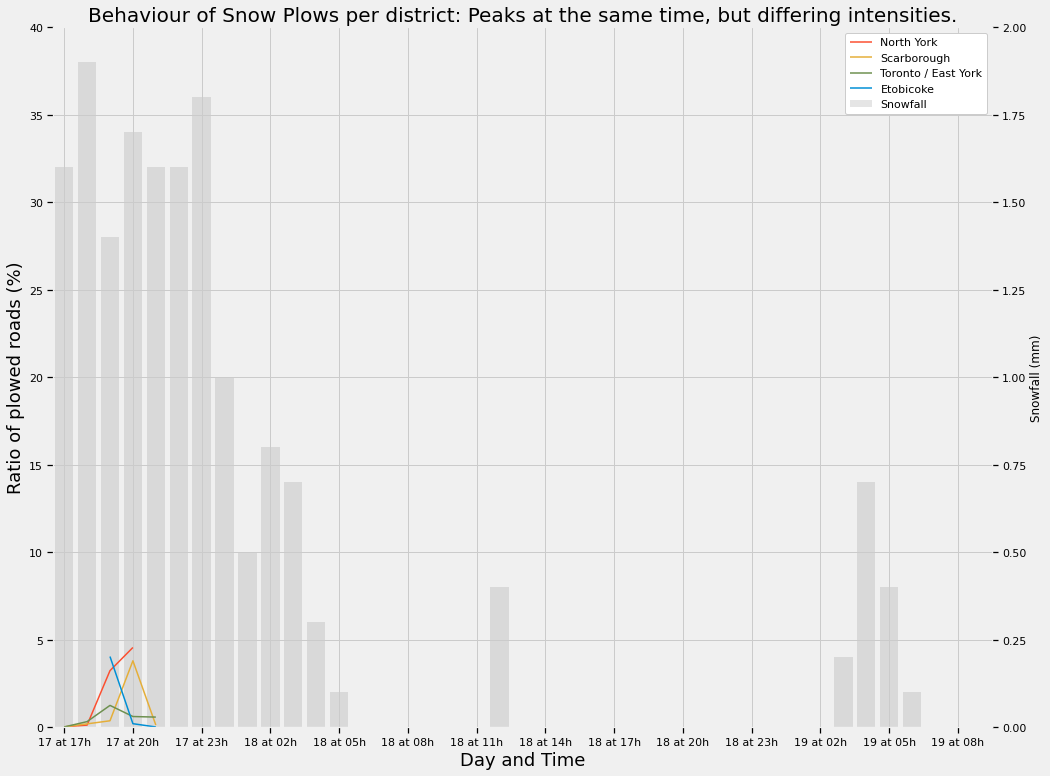

In [13]:
plot_districts(save_fig=False)

In [14]:
try:
    road_types_plowed
except NameError:
    print('df per type of road not found, grabbing it now')
    total_per_type = boundaries_df.reset_index().groupby(by='FEATURE_CODE_DESC').agg(total_length = ('length', 'sum'))

    plowed_streets = gpd.read_file(os.path.join(final_df_folder, r'17_printable_final_df.geojson'))
    roads_plowed_by_type = plowed_streets.groupby(by=['completed_time', 'route_name']).agg(length_plowed = ('length', 'sum'))

    roads_plowed_by_type.reset_index(inplace=True)
    total_per_type.reset_index(inplace=True)

    road_types_plowed = pd.merge(left=roads_plowed_by_type, right=total_per_type, left_on='route_name', right_on='FEATURE_CODE_DESC').drop('FEATURE_CODE_DESC', axis=1)
    road_types_plowed.head()
    road_types = ['Collector','Local','Major Arterial','Minor Arterial']
    road_types_plowed = road_types_plowed[road_types_plowed['route_name'].isin(road_types)]
    road_types_plowed['length_ratio'] = 100*(road_types_plowed['length_plowed'] / road_types_plowed['total_length'])

    road_types_plowed['dt_time'] = pd.to_datetime(road_types_plowed['completed_time'])
    road_types_plowed = road_types_plowed[road_types_plowed.dt_time >= start_time]
    road_types_plowed = road_types_plowed[road_types_plowed.dt_time <= end_time]
    road_types_plowed['time'] = road_types_plowed['dt_time'].dt.strftime("%d at %Hh")
try:
    weather
except NameError:
    print('weather data not found, grabbing it now')
    weather = pd.read_csv('src/Weather Data/YTZ_weather.')
    columns_keep = ['Precip. Amount (mm)', 'Date/Time (LST)']
    weather = weather[columns_keep]
    weather['Date/Time (LST)'] = pd.to_datetime(weather['Date/Time (LST)'])
    weather = weather[weather['Date/Time (LST)'] >= start_time]
    weather = weather[weather['Date/Time (LST)'] <= end_time]
    weather['Day and Hour'] = weather['Date/Time (LST)'].dt.strftime("%d at %Hh")
    weather.rename({'Precip. Amount (mm)':'Snowfall (mm)'}, axis=1, inplace=True)

        #If the df is not loaded into memory, this script will load it.
def plot_road_type(save_fig = True):
    print('Starting the figure')
    #plt.figure(figsize=(15,12))
    print('plotting first axis')
    plt.figure(figsize=(15, 12))
    ax = sns.lineplot(data=road_types_plowed, x='time', y='length_ratio', hue='route_name')
    #this snippet will hide the barplot behind the lineplot
    ax.set_zorder(10)
    ax.patch.set_visible(False)
    
    #plotting snowfall data on secondary axis
    print('plotting secondary axis')
    ax2 = ax.twinx()
    sns.barplot(data=weather, x='Day and Hour', y='Snowfall (mm)', ax=ax2, color='grey', alpha=0.2, label='Snowfall')
    
    #PArameter configs:
    #Reduce number of xticks to 15 bins
    ax.xaxis.set_major_locator(plt.MaxNLocator(15))
    
    print('Configuring ticks and limits')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_ylim(0,40)
    ax2.set_ylim(0,2)

    print('Title and axis labels')
    plt.title('Behaviour of Snow Plows per type of road: Peaks occur after snow stopped \n falling, and outside of commuting hours', fontsize=20)
    ax.set_ylabel('Ratio of plowed roads (%)', fontsize=18)
    ax.set_xlabel('Day and Time', fontsize=18)
    
    #Configuring legends. I want to have legends from both axis in the same box.
    print('Legends')
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, fancybox=True, facecolor='white', framealpha=1)
    #save figure or not
    if save_fig == True:
        print('Picture is being saved')
        plt.savefig('plowed_roads_road_type.png', dpi=1200)
    print('showing')
    plt.show()

df per type of road not found, grabbing it now


Starting the figure
plotting first axis
plotting secondary axis
Configuring ticks and limits
Title and axis labels
Legends
showing


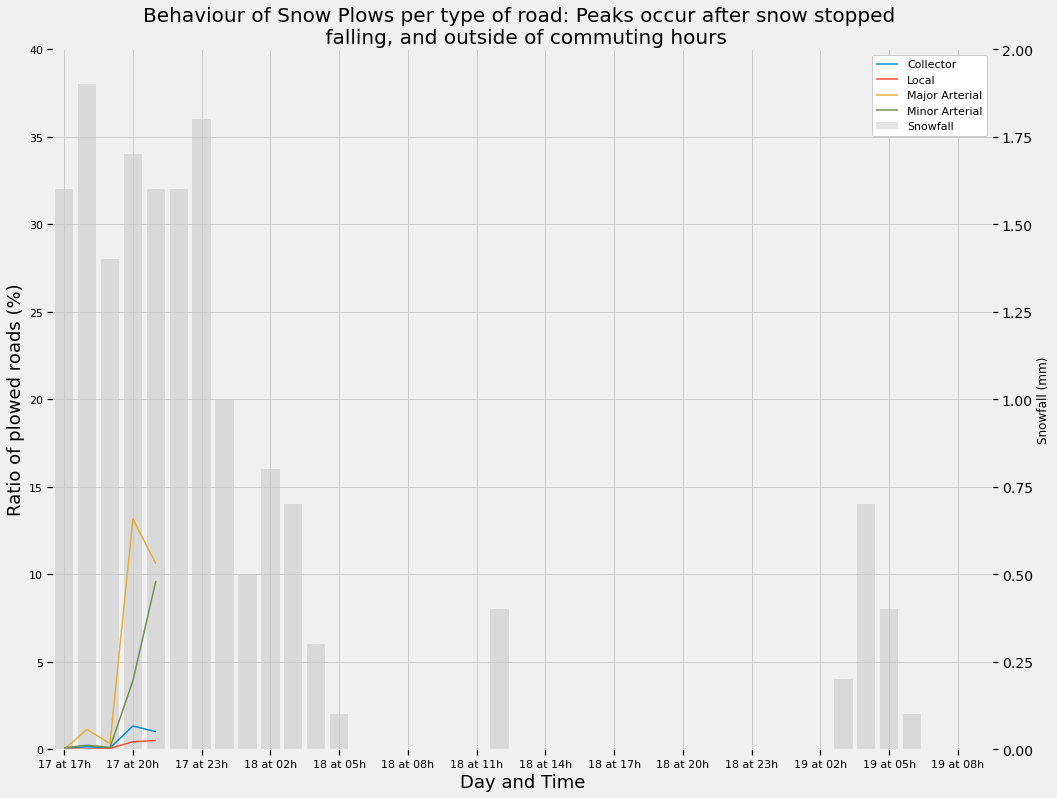

In [15]:
plot_road_type(save_fig=False)